# IMPORT DES LIBRAIRIES

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# OPTIONS PANDAS 

In [18]:
pd.options.display.float_format = '{:.0f}'.format

# OUVERTURE DE NOTRE DATASET

In [19]:
df = pd.read_csv('../DATA/IN/new_extract_gold_dvf.csv', sep=';')
df.head()

,IDVentes,Prix,Date,SurfaceTerrain,SurfaceBati,SurfaceCarrez,NombreLots,NombrePiecesPrincipales,CodePostal,TypeLocalName
0,174617,103950,2021-01-06,0,19,"19,01",1,1,33600,Appartement
1,174618,214380,2021-01-05,0,38,"38,57",2,1,33000,Appartement
2,174619,177000,2021-01-08,0,63,0,3,1,33320,Appartement
3,174620,153000,2021-01-08,0,30,0,2,1,33800,Appartement
4,174621,223170,2021-01-08,0,61,0,3,1,33127,Appartement


# PREMIERES ANALYSES
## ANALYSES DES TYPES DE DONNEES

In [20]:
df.dtypes

IDVentes                    int64
Prix                       object
Date                       object
SurfaceTerrain              int64
SurfaceBati                 int64
SurfaceCarrez              object
NombreLots                  int64
NombrePiecesPrincipales     int64
CodePostal                  int64
TypeLocalName              object
dtype: object

#### COLONNES OU IL FAUT CHANGER DE TYPE DE DONNEES :

- Prix à transformer en float
- Toutes les surfaces carrez à transformer en float comme valeur foncière
- NoVoie à transformer en int
- NombrePiecesPrincipales à transformer en int

# PREMIERES MODIFICATIONS

In [21]:
# Modification of Prix
df['Prix'] = df['Prix'].str.replace(',', '.').astype(float)

In [22]:
# Modification of SurfaceCarrez
df['SurfaceCarrez'] = df['SurfaceCarrez'].str.replace(',', '.').astype(float)

# VERIFICATIONS DES BON CHANGEMENTS DE TYPE

In [23]:
df.dtypes

IDVentes                     int64
Prix                       float64
Date                        object
SurfaceTerrain               int64
SurfaceBati                  int64
SurfaceCarrez              float64
NombreLots                   int64
NombrePiecesPrincipales      int64
CodePostal                   int64
TypeLocalName               object
dtype: object

# NOMBRE D'INDIVIDU DE NOTRE DATASET

In [24]:
df_shape = df.shape 
print(f'Notre Dataset comprend {df_shape[0]} Individus et {df_shape[1]} Features')

Notre Dataset comprend 174616 Individus et 10 Features


# ANALYSE

## ANALYSE DESCRIPTIVES DES FEATURES QUANTITATIVES

In [25]:
df.describe()

,IDVentes,Prix,SurfaceTerrain,SurfaceBati,SurfaceCarrez,NombreLots,NombrePiecesPrincipales,CodePostal
count,174616,174616,174616,174616,174616,174616,174616,174616
mean,261924,603123,2045,87,11,4,0,33403
std,50407,1910968,15628,49,33,2,1,264
min,174617,1,0,1,0,0,0,33000
25%,218271,166000,0,54,0,2,0,33185
50%,261924,260000,272,80,0,4,0,33380
75%,305578,419072,700,108,0,4,1,33610
max,349232,72277368,382680,1000,6202,54,17,33990


#### PENSER A VERIFIER LES DATA QUALITATIVE (STRING)

- Certains biens ne semblent pas avoir de valeur foncière (174 644 VF pour 175 017 bien) sachant que c'est notre Label, nous supprimerons les individus avec cette valeur manquante.
- Certains biens semblent avoir une VF Outliers (MAX 7 227 736 800 et MIN 1) verif. leurs nombres
- Les Prefix. de Section ne sont pas renseignés (888 pour 175 017 biens...) on ne pourra pas s'appuyer sur le cadastre pour construire une DATA VIZ géographique 
- Pour rappel Code Type Local : 
    - 1 Maison 
    - 2 Appt.
- 6 biens n'ont pas de Surface Réel Bati., nous supprimerons ces individus
- Idems pour Nombre de pièçes principales (de plus certains biens sont outliers sur cette variable) on a des biens à 0 et des bien à 54 
- Pour la surface du terrain, certains biens sont à 0, d'autre ont une surface de 382 680 vérif. les outliers.

# PREMIERES FEATURES ENGINEERING

 ### AJOUT D'UNE FOURCHETTE DE PRIX

In [26]:
# Définir les tranches de valeur foncière
bins = [50000, 100000, 150000, 200000, 250000, 300000, 400000, 500000, 600000, 750000, 1000000, 1500000, 2000000, 3000000, 4000000, 5000000, 6000000, df['Prix'].max()]

# Utiliser cut pour créer une nouvelle colonne 'Tranche'
df['slice'] = pd.cut(df['Prix'], bins=bins, right=False)

### AFFICHAGE DU NOMBRE DE BIENS PAR FOURCHETTE DE PRIX DE VENTE

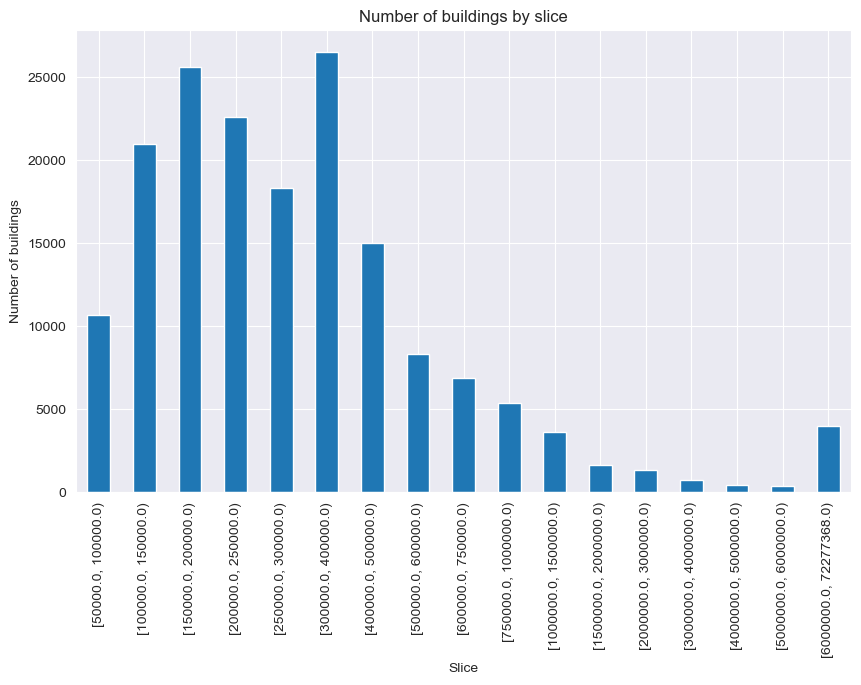

In [27]:
# Compter les biens par tranche
tranche_count = df['slice'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(10, 6))
tranche_count.plot(kind='bar')
plt.title('Number of buildings by slice')
plt.xlabel('Slice')
plt.ylabel('Number of buildings')
plt.show()

### CONCLUSIONS 
La majeure partie des biens immobilliers se concentre entre 100 000 ET 500 000 Euros, ce qui est une tranche convenable pour notre ML

# CREATION D'UNE CARTE CHAUDE POUR VOIR LES CORRELATION ENTRE LES FEATURES QUANTITATIVE ET NOTRE PRIX DE VENTE

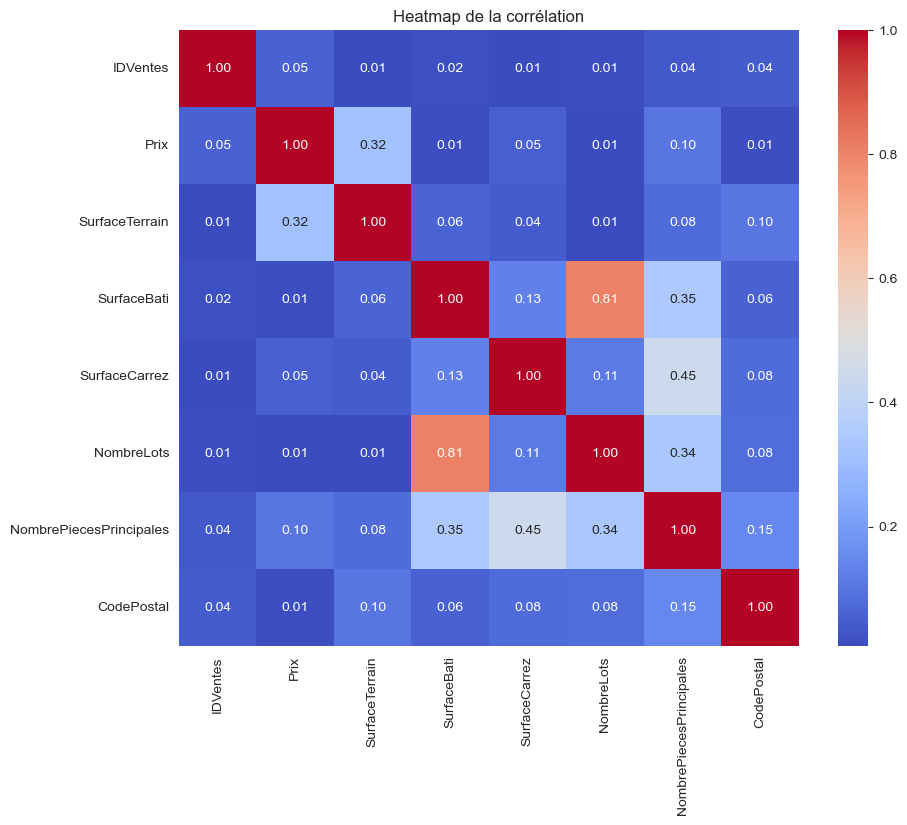

In [28]:
# Supprimer les colonnes non numériques
cols_to_drop = ['Date']
df_num = df.drop(columns=cols_to_drop)

# Convertir toutes les colonnes en numérique, ignorer les erreurs ('coerce' crée NaN pour les non convertibles)
df_num = df_num.apply(pd.to_numeric, errors='coerce')

# Supprimer les colonnes avec toutes les valeurs NaN résultant de la conversion
df_num = df_num.dropna(axis=1, how='all')

# Calculer la matrice de corrélation sur les colonnes restantes
corr_df_num = abs(df_num.corr())

# Utiliser Seaborn pour créer une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df_num, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap de la corrélation')
plt.show()

## ANALYSE DES DATES DE VENTES

### FEATURES ENGINEERING POUR CREER DE NOUVELLES FEATURES TEMPORELLES

In [29]:
# Convertir la colonne 'DateMutation' en datetime si ce n'est pas déjà fait
df['Date'] = pd.to_datetime(df['Date'])

# Extraire le numéro du trimestre de chaque date
df['quarter'] = df['Date'].dt.quarter

# Extraire l'année 
df['Year'] = df['Date'].dt.year

# Extraire le mois 
df['Month'] = df['Date'].dt.month

df

,IDVentes,Prix,Date,SurfaceTerrain,SurfaceBati,SurfaceCarrez,NombreLots,NombrePiecesPrincipales,CodePostal,TypeLocalName,slice,quarter,Year,Month
0,174617,103950,2021-01-06,0,19,19,1,1,33600,Appartement,"[100000.0, 150000.0)",1,2021,1
1,174618,214380,2021-01-05,0,38,39,2,1,33000,Appartement,"[200000.0, 250000.0)",1,2021,1
2,174619,177000,2021-01-08,0,63,0,3,1,33320,Appartement,"[150000.0, 200000.0)",1,2021,1
3,174620,153000,2021-01-08,0,30,0,2,1,33800,Appartement,"[150000.0, 200000.0)",1,2021,1
4,174621,223170,2021-01-08,0,61,0,3,1,33127,Appartement,"[200000.0, 250000.0)",1,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174611,349228,140000,2023-06-28,1922,200,0,8,0,33860,Maison,"[100000.0, 150000.0)",2,2023,6
174612,349229,80000,2023-06-29,237,73,0,4,0,33820,Maison,"[50000.0, 100000.0)",2,2023,6
174613,349230,155000,2023-05-02,600,78,0,4,0,33830,Maison,"[150000.0, 200000.0)",2,2023,5
174614,349231,111150,2023-06-28,51,82,0,2,0,33210,Maison,"[100000.0, 150000.0)",2,2023,6


# ANALYSE DES PRIX DE VENTES ET DES VOLUMETRIES DE VENTES PAR PERIODES

## ANALYSE DU PRIX DE VENTE PAR ANS 

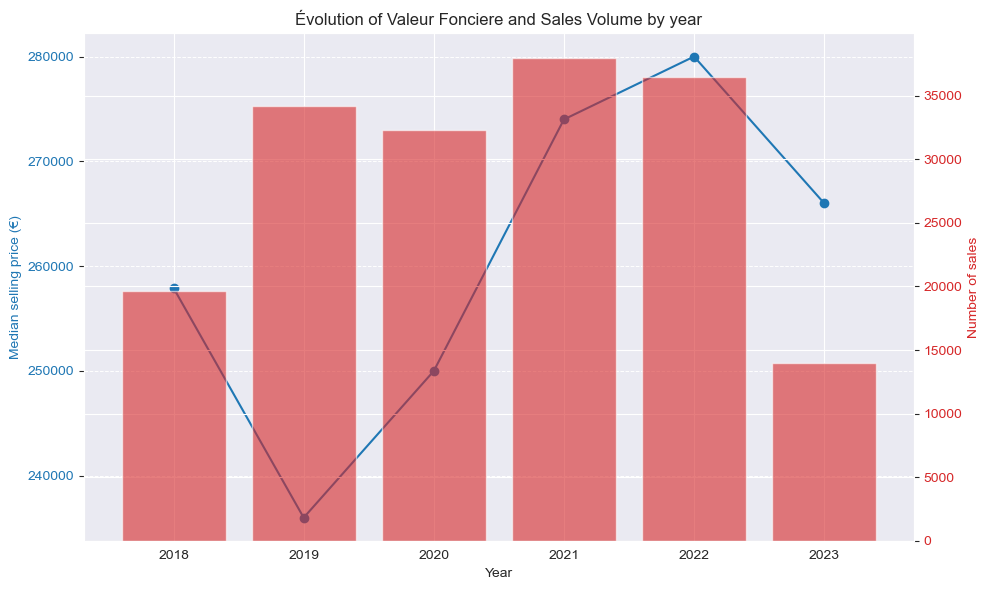

In [30]:
# DataFrame filtré sur les années pleines
# df_year = df.loc[(df['Year'] >= 2019) & (df['Year'] <= 2022)]

# Calculer le prix médian par année
average_price_per_year = df.groupby('Year')['Prix'].median()

# Calculer la volumétrie des ventes par année
sales_volume_per_year = df.groupby('Year').size()

# Créer une figure et un premier axe pour le line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Median selling price (€)', color=color)
ax1.plot(average_price_per_year.index, average_price_per_year, marker='o', color=color)  # corrected line
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='plain', axis='y')

# Créer un second axe pour le bar chart
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of sales', color=color)
ax2.bar(sales_volume_per_year.index, sales_volume_per_year, color=color, alpha=0.6, label='Number of Sales')  # corrected line
ax2.tick_params(axis='y', labelcolor=color)

# Ajouter des titres et du grid
plt.title('Évolution of Valeur Fonciere and Sales Volume by year')
ax1.grid(axis='y', linestyle='--', linewidth=0.7)

# Montrer le graphique
fig.tight_layout()
plt.show()

## CONCLUSIONS :

On observe un prix median en net augmentation entre 2020 et 2021, il est donc important de garder cette feature dans notre model.

### ANALYS BY QUARTER

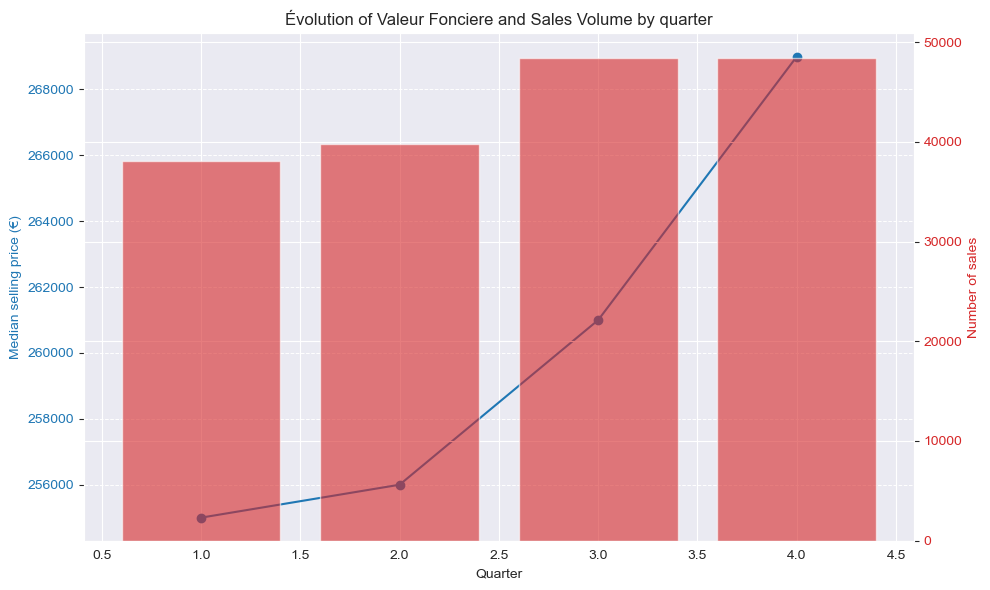

In [31]:
# Calculer le prix médian par trimestre
average_price_per_quarter = df.groupby('quarter')['Prix'].median()

# Calculer la volumétrie des ventes par trimestre
sales_volume_per_quarter = df.groupby('quarter').size()

# Créer une figure et un premier axe pour le line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Median selling price (€)', color=color)
ax1.plot(average_price_per_quarter.index, average_price_per_quarter, marker='o', color=color)  
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='plain', axis='y')

# Créer un second axe pour le bar chart
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of sales', color=color)
ax2.bar(sales_volume_per_quarter.index, sales_volume_per_quarter, color=color, alpha=0.6, label='Number of Sales')  # corrected line
ax2.tick_params(axis='y', labelcolor=color)

# Ajouter des titres et du grid
plt.title('Évolution of Valeur Fonciere and Sales Volume by quarter')
ax1.grid(axis='y', linestyle='--', linewidth=0.7)

# Montrer le graphique
fig.tight_layout()
plt.show()

## CONCLUSIONS :

On observe une légère augmentation du prix median suivant le trimestre, ce prix influe de 17500 euros, cette features n'est peut-être pas si importante

### ANALYSE PAR MOIS

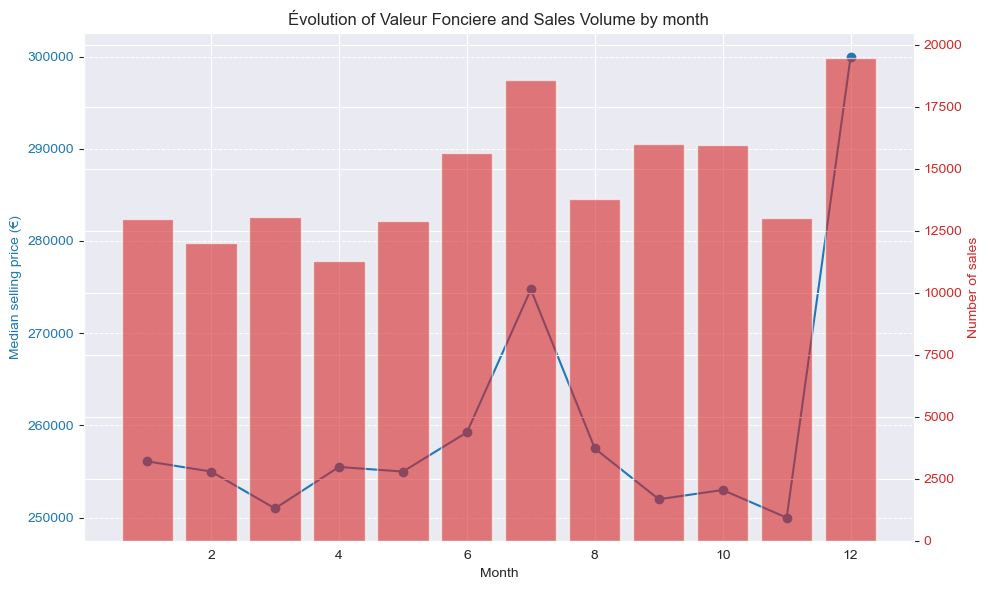

In [32]:
# Calculer le prix médian par mois
average_price_per_month = df.groupby('Month')['Prix'].median()

# Calculer la volumétrie des ventes par mois
sales_volume_per_month = df.groupby('Month').size()

# Créer une figure et un premier axe pour le line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Median selling price (€)', color=color)
ax1.plot(average_price_per_month.index, average_price_per_month, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='plain', axis='y')

# Créer un second axe pour le bar chart
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of sales', color=color)
ax2.bar(sales_volume_per_month.index, sales_volume_per_month, color=color, alpha=0.6, label='Number of Sales')  # corrected line
ax2.tick_params(axis='y', labelcolor=color)

# Ajouter des titres et du grid
plt.title('Évolution of Valeur Fonciere and Sales Volume by month')
ax1.grid(axis='y', linestyle='--', linewidth=0.7)

# Montrer le graphique
fig.tight_layout()
plt.show()

## CONCLUSIONS :

On observe, 2 pics de valeurs en termes de ventes et de prix median en juillet et en aout, il faudrait vérifier nos outliers voir à quels moments ils ont été vendues, et rejouer l'analyse, sans ces outliers

## ANALYSE DES TYPE DE BIENS IMMOBILIER (Appt, Maison)

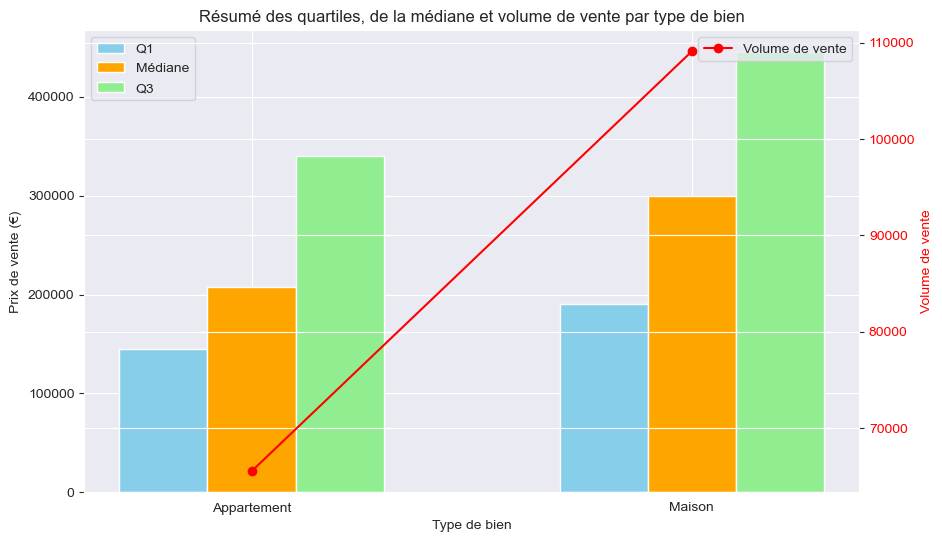

In [34]:
# Calcul des statistiques descriptives pour chaque 'CodeTypeLocal'
stats_df = df.groupby('TypeLocalName')['Prix'].describe()

# Sélection des quartiles et de la médiane pour chaque 'CodeTypeLocal'
quartiles_df = stats_df.loc[:, ['25%', '50%', '75%']]
quartiles_df.columns = ['Q1', 'Médiane', 'Q3']

# Calcul de la volumétrie des ventes pour chaque 'CodeTypeLocal'
volumes_df = df['TypeLocalName'].value_counts().reindex(quartiles_df.index)

# Création des graphiques en barres pour chaque quartile et la médiane
fig, ax1 = plt.subplots(figsize=(10, 6))

# Position sur l'axe des x pour chaque 'CodeTypeLocal' et les groupes de barres
ind = np.arange(len(quartiles_df))  # l'emplacement x des groupes
width = 0.2  # la largeur des barres

# Barres pour Q1
ax1.bar(ind - width, quartiles_df['Q1'], width, color='skyblue', label='Q1')

# Barres pour la Médiane
ax1.bar(ind, quartiles_df['Médiane'], width, color='orange', label='Médiane')

# Barres pour Q3
ax1.bar(ind + width, quartiles_df['Q3'], width, color='lightgreen', label='Q3')

# Configuration de l'axe des x
ax1.set_xlabel('Type de bien')
ax1.set_ylabel('Prix de vente (€)')
ax1.set_title('Résumé des quartiles, de la médiane et volume de vente par type de bien')
ax1.set_xticks(ind)
ax1.set_xticklabels(quartiles_df.index)
ax1.legend(loc='upper left')

# Créer un second axe pour le volume des ventes
ax2 = ax1.twinx()
ax2.plot(ind, volumes_df, color='red', marker='o', label='Volume de vente')
ax2.set_ylabel('Volume de vente', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.show()


### CONCLUSIONS :

On Observe que le type d'individu numéro 2 est sous représenté en terme de volumétrie de vente. 
Concernant le prix médian, ce dernier est nettement inférieur également.

## ANALYSE DU PRIX SELON LSI IL Y AS UN TERRAIN OU NON (FEATURE ENGINEERING POUR CREATION DE LA FEATURE AvecTerrain)

C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\3718010504.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Sans terrain', 'Avec terrain'])
C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\3718010504.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volumetrie_terrain.index, y=volumetrie_terrain.values, ax=ax2, palette=['red', 'darkred'], alpha=0.6)
C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\3718010504.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Sans terrain', 'Avec terrain'])


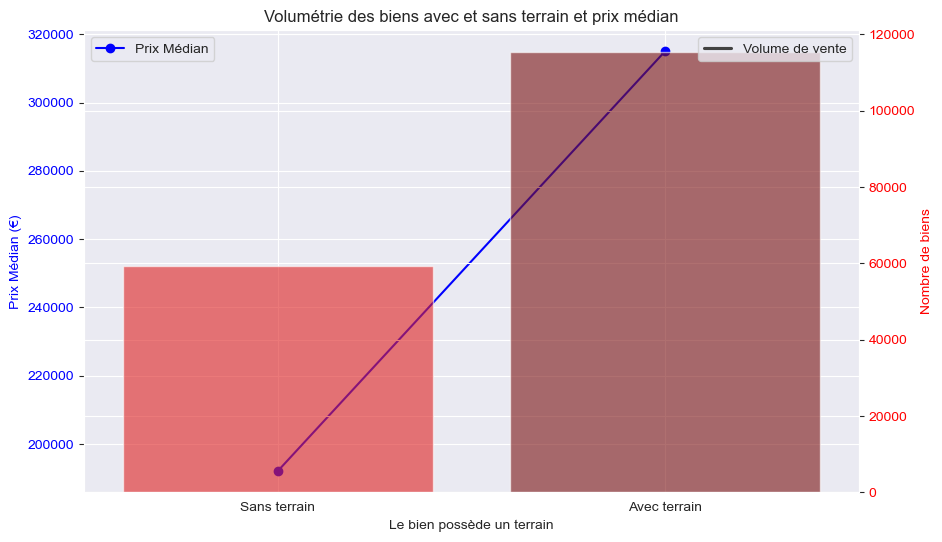

In [35]:
# Préparation des données
df['AvecTerrain'] = df['SurfaceTerrain'] > 0

# Calculer le nombre de biens avec et sans terrain
volumetrie_terrain = df.groupby('AvecTerrain').size()

# Calculer le prix médian pour les biens avec et sans terrain
prix_median_terrain = df.groupby('AvecTerrain')['Prix'].median()

# Création du bar plot pour la volumétrie
fig, ax1 = plt.subplots(figsize=(10, 6))

# Configurer l'axe des y pour le prix médian en bleu
ax1.set_ylabel('Prix Médian (€)', color='blue')
ax1.plot(prix_median_terrain.index, prix_median_terrain.values, color='blue', marker='o', label='Prix Médian')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(['Sans terrain', 'Avec terrain'])
ax1.legend(loc='upper left')

# Créer un second axe pour la volumétrie des biens
ax2 = ax1.twinx()

# Configurer l'axe des y pour la volumétrie en rouge
ax2.set_ylabel('Nombre de biens', color='red')
sns.barplot(x=volumetrie_terrain.index, y=volumetrie_terrain.values, ax=ax2, palette=['red', 'darkred'], alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_xticklabels(['Sans terrain', 'Avec terrain'])
ax2.legend(['Volume de vente'], loc='upper right')

# Configurer le titre et les étiquettes de l'axe des x
ax1.set_title('Volumétrie des biens avec et sans terrain et prix médian')
ax1.set_xlabel('Le bien possède un terrain')

plt.show()

### CONCLUSIONS :

On observe un nombre d'individu multiplié par 2 sur le label avec terrain, ainsi que le prix median qui boost de 1,5X environ

## ANALYSE DU PRIX MEDIAN SUIVANT LA SURFACE DE TERRAIN 

C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\2992818533.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prix_moyen_par_surface_terrain = biens_avec_terrain.groupby('SurfaceTerrainCat')['Prix'].median()
C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\2992818533.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45)


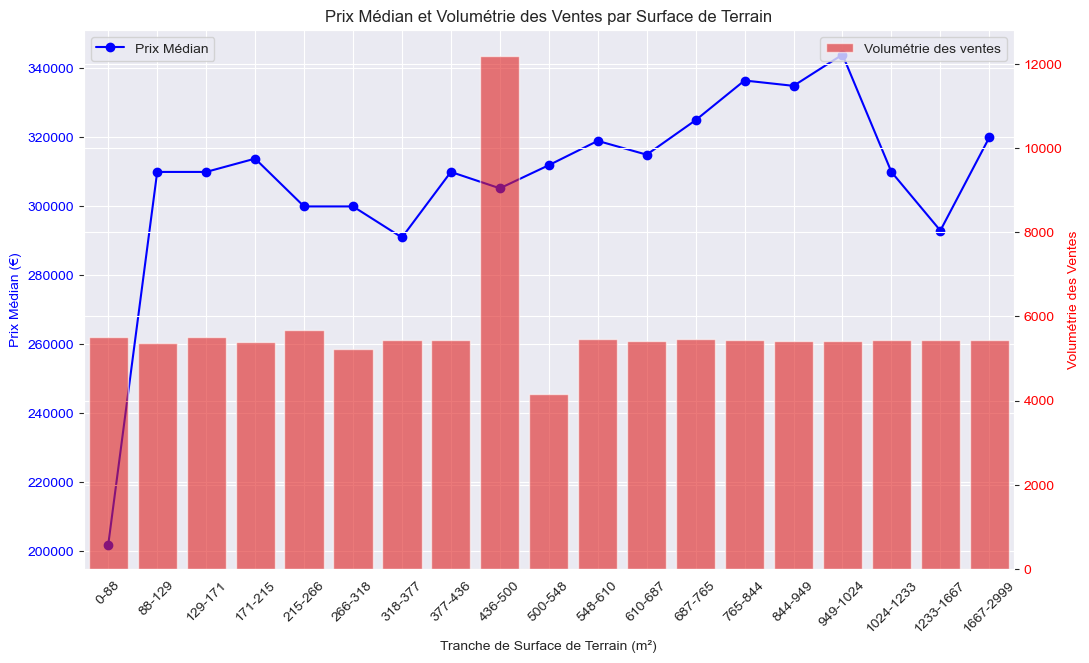

In [36]:

# Filtrez pour ne garder que les biens avec un terrain 
biens_avec_terrain = df.loc[(df['AvecTerrain'] == True) & (df['SurfaceTerrain'] < 3000)].copy()

# Découpez la surface du terrain en tranches égales selon les quantiles
# Notez que nous utilisons `duplicates='drop'` pour éviter les erreurs dans les cas où il y aurait des quantiles identiques
biens_avec_terrain['SurfaceTerrainCat'] = pd.qcut(biens_avec_terrain['SurfaceTerrain'], q=20, duplicates='drop')

# Calculez le prix médian de vente pour chaque tranche de surface de terrain
prix_moyen_par_surface_terrain = biens_avec_terrain.groupby('SurfaceTerrainCat')['Prix'].median()

# Calculez la volumétrie des biens pour chaque tranche de surface de terrain
volumetrie_par_surface_terrain = biens_avec_terrain['SurfaceTerrainCat'].value_counts().reindex(prix_moyen_par_surface_terrain.index)

# Convertissez les intervalles en chaînes pour l'axe x
labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in prix_moyen_par_surface_terrain.index]

# Créez une figure et un premier axe
fig, ax1 = plt.subplots(figsize=(12, 7))

# Créez le line chart pour le prix médian en bleu sur l'axe ax1
ax1.plot(labels, prix_moyen_par_surface_terrain.values, color='blue', marker='o', label='Prix Médian')
ax1.set_xlabel('Tranche de Surface de Terrain (m²)')
ax1.set_ylabel('Prix Médian (€)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(loc='upper left')

# Ajoutez un deuxième axe pour la volumétrie des ventes
ax2 = ax1.twinx()

# Créez le bar plot pour la volumetrie en rouge sur l'axe ax2
sns.barplot(x=labels, y=volumetrie_par_surface_terrain.values, ax=ax2, color='red', alpha=0.6, label='Volumétrie des ventes')
ax2.set_ylabel('Volumétrie des Ventes', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Mettez un titre au graphique
plt.title('Prix Médian et Volumétrie des Ventes par Surface de Terrain')

plt.show()

### CONCLUSIONS :

On observe un nombre d'individu par tranche de surface terrain similaire qui est dut à notre méthode QCUT, néamoins, le prix median lui semble adopter une légère courbe linéaire.

# ANALYSE DU PRIX DE VENTE PAR SURFACE BATI 

C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\3772031237.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prix_moyen_par_surface_bati = df.groupby('SurfaceBatiCat')['Prix'].median()
C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\3772031237.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45)


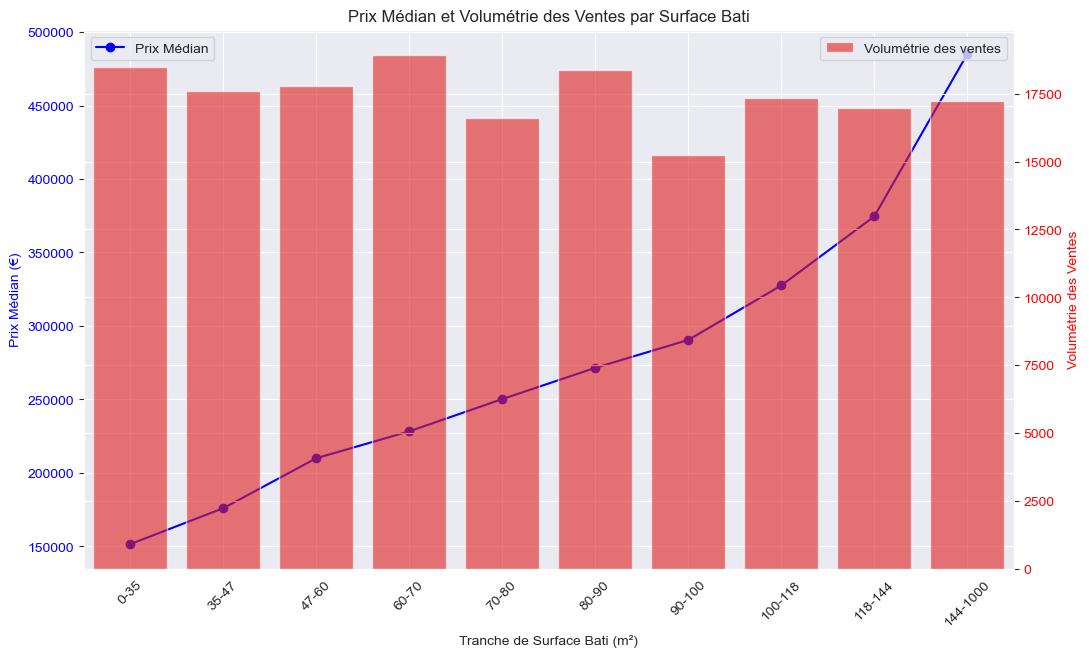

In [37]:

# Découpez la surface du terrain en tranches égales selon les quantiles
# Notez que nous utilisons `duplicates='drop'` pour éviter les erreurs dans les cas où il y aurait des quantiles identiques
df['SurfaceBatiCat'] = pd.qcut(df['SurfaceBati'], q=10, duplicates='drop')

# Calculez le prix médian de vente pour chaque tranche de surface de terrain
prix_moyen_par_surface_bati = df.groupby('SurfaceBatiCat')['Prix'].median()

# Calculez la volumétrie des biens pour chaque tranche de surface de terrain
volumetrie_par_surface_bati = df['SurfaceBatiCat'].value_counts().reindex(prix_moyen_par_surface_bati.index)

# Convertissez les intervalles en chaînes pour l'axe x
labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in prix_moyen_par_surface_bati.index]

# Créez une figure et un premier axe
fig, ax1 = plt.subplots(figsize=(12, 7))

# Créez le line chart pour le prix médian en bleu sur l'axe ax1
ax1.plot(labels, prix_moyen_par_surface_bati.values, color='blue', marker='o', label='Prix Médian')
ax1.set_xlabel('Tranche de Surface Bati (m²)')
ax1.set_ylabel('Prix Médian (€)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(loc='upper left')

# Ajoutez un deuxième axe pour la volumétrie des ventes
ax2 = ax1.twinx()

# Créez le bar plot pour la volumetrie en rouge sur l'axe ax2
sns.barplot(x=labels, y=volumetrie_par_surface_bati.values, ax=ax2, color='red', alpha=0.6, label='Volumétrie des ventes')
ax2.set_ylabel('Volumétrie des Ventes', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Mettez un titre au graphique
plt.title('Prix Médian et Volumétrie des Ventes par Surface Bati')

plt.show()

### CONCLUSIONS :

On observe une courbe linéaire du prix médian suivant la surface Bati, cette feature est donc très importante pour notre Model.

# ANALYSE DU PRIX SELON LA SURFACE CARREZ TOTAL (FEATURE ENGINEERING POUR LA CREATION DE LA FEATURE SurfaceCarrez

C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\1174749452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biens_carrez['SurfaceCarrezCat'] = pd.qcut(biens_carrez['SurfaceCarrez'], q=50, duplicates='drop')
C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\1174749452.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prix_moyen_par_surface_carrez = biens_carrez.groupby('SurfaceCarrezCat')['Prix'].median()
C:\Users\jonat\AppData\Local\Temp\ipykernel_31848\1174749452.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i

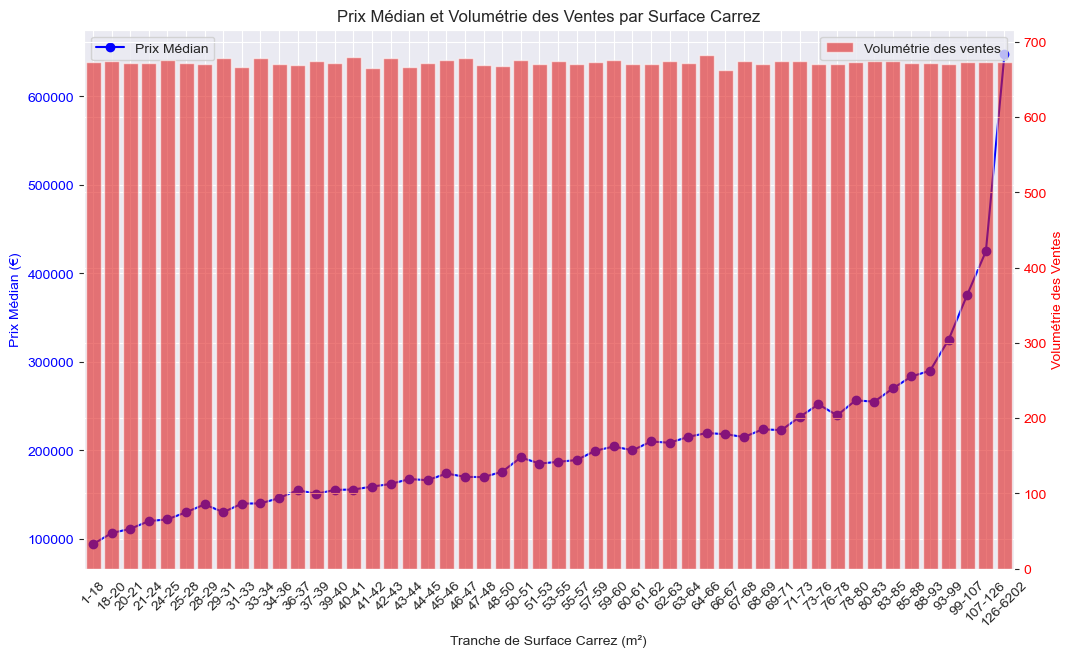

In [38]:
# On garde seulement pour cette analys les biens avec une surface carrez
biens_carrez = df[(df['SurfaceCarrez'] > 0)]

# Découpez la surface carrez en tranches égales selon les quantiles
# Notez que nous utilisons `duplicates='drop'` pour éviter les erreurs dans les cas où il y aurait des quantiles identiques
biens_carrez['SurfaceCarrezCat'] = pd.qcut(biens_carrez['SurfaceCarrez'], q=50, duplicates='drop')

# Calculez le prix médian de vente pour chaque tranche de surface de terrain
prix_moyen_par_surface_carrez = biens_carrez.groupby('SurfaceCarrezCat')['Prix'].median()

# Calculez la volumétrie des biens pour chaque tranche de surface de terrain
volumetrie_par_surface_carrez = biens_carrez['SurfaceCarrezCat'].value_counts().reindex(prix_moyen_par_surface_carrez.index)

# Convertissez les intervalles en chaînes pour l'axe x
labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in prix_moyen_par_surface_carrez.index]

# Créez une figure et un premier axe
fig, ax1 = plt.subplots(figsize=(12, 7))

# Créez le line chart pour le prix médian en bleu sur l'axe ax1
ax1.plot(labels, prix_moyen_par_surface_carrez.values, color='blue', marker='o', label='Prix Médian')
ax1.set_xlabel('Tranche de Surface Carrez (m²)')
ax1.set_ylabel('Prix Médian (€)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(loc='upper left')

# Ajoutez un deuxième axe pour la volumétrie des ventes
ax2 = ax1.twinx()

# Créez le bar plot pour la volumetrie en rouge sur l'axe ax2
sns.barplot(x=labels, y=volumetrie_par_surface_carrez.values, ax=ax2, color='red', alpha=0.6, label='Volumétrie des ventes')
ax2.set_ylabel('Volumétrie des Ventes', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Mettez un titre au graphique
plt.title('Prix Médian et Volumétrie des Ventes par Surface Carrez')

plt.show()

### CONCLUSIONS :

On observe une courbe linéaire du prix médian suivant la surface Carrez, cette feature est donc très importante pour notre Model.
## REPARTITION DU PRIX DE VENTES PAR NOMBRE DE PIECES PRINCIPALES

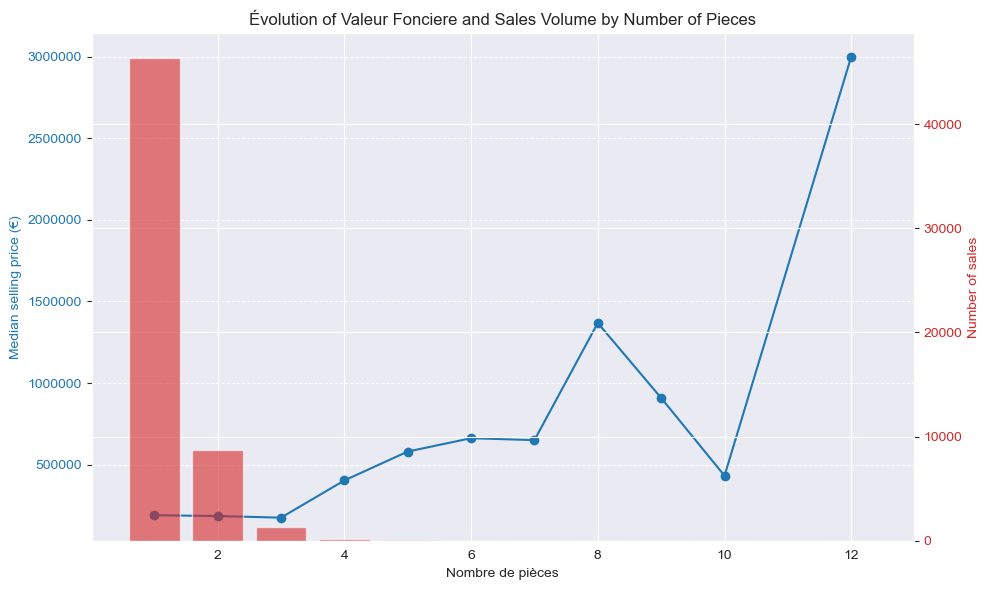

In [39]:
bien_avec_pieces = df[(df['NombrePiecesPrincipales'] > 0) & (df['NombrePiecesPrincipales'] < 13)]

# Calculer le prix médian par nombre de pieces
average_price_per_pieces = bien_avec_pieces.groupby('NombrePiecesPrincipales')['Prix'].median()

# Calculer la volumétrie des ventes par mois
sales_volume_per_pieces = bien_avec_pieces.groupby('NombrePiecesPrincipales').size()

# Créer une figure et un premier axe pour le line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Nombre de pièces')
ax1.set_ylabel('Median selling price (€)', color=color)
ax1.plot(average_price_per_pieces.index, average_price_per_pieces, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='plain', axis='y')

# Créer un second axe pour le bar chart
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of sales', color=color)
ax2.bar(sales_volume_per_pieces.index, sales_volume_per_pieces, color=color, alpha=0.6, label='Number of Sales')  # corrected line
ax2.tick_params(axis='y', labelcolor=color)

# Ajouter des titres et du grid
plt.title('Évolution of Valeur Fonciere and Sales Volume by Number of Pieces')
ax1.grid(axis='y', linestyle='--', linewidth=0.7)

# Montrer le graphique
fig.tight_layout()
plt.show()

### CONCLUSIONS

La majorité d'individu à un nombre de pièce allant de 1 à 6, le reste pourrait s'apparenter à des outliers, néamoins le prix median semble suivre une courbe linéaire jusqu'au individus avec 12 pièces.
Cette feature est donc trés importante dans notre modèl.


# EXPORT D'UN CSV AVEC NOS MODIFICATION DE DONNES ET PREPROCESSING

In [41]:
df.to_csv('../DATA/OUT/new_dataset_with_data_prepocessing.csv', index=False)